In [1]:
import numpy as np
import pandas as pd

#remove the row and column label from excel sheet before loading

#dataset import for regressor
X_dem=pd.read_excel(r'C:\Users\fhasan1\dataset39.xlsx', header=None, sheet_name=0)#demand data
y_gen=pd.read_excel(r'C:\Users\fhasan1\dataset39.xlsx', header=None, sheet_name=1)#generation data

#Changing pandas dataframe to numpy array
X_dem = X_dem.to_numpy()
y_gen = y_gen.to_numpy()

# load new voltage and brnach status dataset for classification
y_bus=pd.read_excel(r'C:\Users\fhasan1\dataset39.xlsx', header=None, sheet_name=2)#outputbus
y_branch=pd.read_excel(r'C:\Users\fhasan1\dataset39.xlsx', header=None, sheet_name=3)#outputbranch

#Changing pandas dataframe to numpy array
y_bus = y_bus.to_numpy()
y_branch = y_branch.to_numpy()

# Generator bus indices
Gen_index=pd.read_excel(r'C:\Users\fhasan1\dataset39.xlsx', header=None, sheet_name=4)
Gen_index=np.array(Gen_index)

# Loading Index_of_nonzero_nodal_demand
load_index=pd.read_excel(r'C:\Users\fhasan1\dataset39.xlsx', header=None, sheet_name=5)
load_index=np.array(load_index)
load_index=load_index-1 #as pyhton starts counting from zero
load_index=load_index.T

#number bus branch and gen
nb=np.size(y_bus,1)#bus
nl=np.size(y_branch,1)#branch
ng=len(Gen_index)#gen

print(nb)
print(nl)
print(ng)

39
46
10


In [2]:
#verifying the size of datasets
print(X_dem.shape)
print(y_gen.shape)
print(y_bus.shape)
print(y_branch.shape)
print(Gen_index.shape)
print(load_index.shape)

(4882, 78)
(4882, 20)
(4882, 39)
(4882, 46)
(10, 1)
(1, 42)


In [3]:
#dataset for regressor training
X_regressor=X_dem[0:2000,0:]
y_regressor=y_gen[0:2000,0:]
print(X_regressor.shape)
print(y_regressor.shape)

(2000, 78)
(2000, 20)


In [4]:
#Filtering zeros from demand
X_regressor=X_regressor[:,load_index[0,0:]]
print(X_regressor.shape)

(2000, 42)


In [5]:
#Train test split of model
from sklearn.model_selection import train_test_split
X_trainG,X_testG,y_trainG,y_testG = train_test_split(X_regressor,y_regressor,test_size = 0.1,random_state = 0)

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [7]:
modelG = Sequential()
modelG.add(Dense(256, input_dim=np.size(X_regressor,1), activation='relu'))
modelG.add(Dense(ng*2, activation='linear'))

modelG.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [8]:
historyG = modelG.fit(X_trainG, y_trainG, epochs=1000, batch_size=100,verbose=0,validation_split=0.2)

In [9]:
print(historyG.history.keys())
# "Loss"

import matplotlib.pyplot as plt

plt.plot(historyG.history['loss'])
plt.plot(historyG.history['val_loss'])
plt.title('Rgression learners loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])


<Figure size 640x480 with 1 Axes>

In [10]:
# testing the trained regressor
import math
from sklearn.metrics import mean_squared_error

# Generation prediction 
y_predG=modelG.predict(X_testG)

RMSE=[]

for x in range(np.size(X_testG,0)): 
    MSE=mean_squared_error(y_testG[x,:], y_predG[x,:])
    RMSE.append(math.sqrt(MSE))
    
mean_RMSE=sum(RMSE)/len(RMSE)
print(mean_RMSE)

28.01431919848996


In [11]:
#dataset for classifier trainig
X_classifier=X_dem[2000:4000,0:]
y_classifier_bus=y_bus[2000:4000,0:]
y_classifier_branch=y_branch[2000:4000,0:]
print(X_classifier.shape)
print(y_classifier_bus.shape)
print(y_classifier_branch.shape)

(2000, 78)
(2000, 39)
(2000, 46)


In [12]:
# Generation prediction
X_classifier_dem=np.copy(X_classifier)
X_classifier_dem=X_classifier_dem[:,load_index[0,0:]]  # ~ is an element-wise inversion

y_predG=modelG.predict(X_classifier_dem)

print(X_classifier_dem.shape)
print(X_classifier.shape)

(2000, 42)
(2000, 78)


In [13]:
#converting (ng*1) to (nb*1) matrix
#As pyhton indexing start from zero
Gen_index=Gen_index-1

y_predG_temp=np.zeros([np.size(X_classifier,0),nb*2], dtype = int)

for s in range(np.size(X_classifier,0)):
    for i in range(ng):    
        y_predG_temp[s,Gen_index[i]]=y_predG[s,i]
        y_predG_temp[s,Gen_index[i]+nb]=y_predG[s,i+ng] #ng=10

In [14]:
#forming net injection vectors
X_NI=y_predG_temp-X_classifier
X_NI.shape

(2000, 78)

In [15]:
#Train test split of model
from sklearn.model_selection import train_test_split
# model for voltage
X_trainV,X_testV,y_trainV,y_testV = train_test_split(X_NI,y_classifier_bus,test_size = 0.1,random_state = 0)
# model for branch
X_trainB,X_testB,y_trainB,y_testB = train_test_split(X_NI,y_classifier_branch,test_size = 0.1,random_state = 0)

In [16]:
#bus slassifier model
modelV = Sequential()
modelV.add(Dense(256, input_dim=np.size(X_NI,1), activation='sigmoid'))
modelV.add(Dense(nb, activation='softmax'))
modelV.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#branch slassifier model
modelB = Sequential()
modelB.add(Dense(256, input_dim=np.size(X_NI,1), activation='sigmoid'))
modelB.add(Dense(nl, activation='softmax'))
modelB.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
historyV = modelV.fit(X_trainV, y_trainV, epochs=1000, batch_size=100,verbose=0,validation_split=0.2)
historyB = modelB.fit(X_trainB, y_trainB, epochs=1000, batch_size=100,verbose=0,validation_split=0.2)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


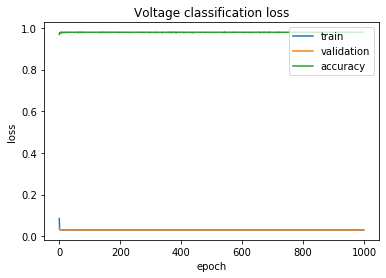

In [18]:
print(historyV.history.keys())
# "Loss"

import matplotlib.pyplot as plt

plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.plot(historyB.history['accuracy'])
plt.title('Voltage classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'accuracy'], loc='upper right')
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


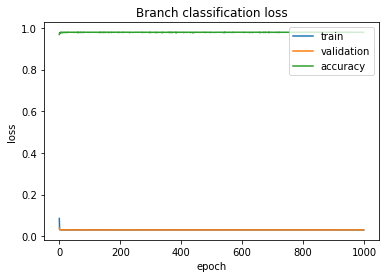

In [19]:
print(historyB.history.keys())
# "Loss"

import matplotlib.pyplot as plt

plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.plot(historyB.history['accuracy'])
plt.title('Branch classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'accuracy'], loc='upper right')
plt.show()

In [20]:
y_predV=modelV.predict(X_testV)
y_predB=modelB.predict(X_testB)
print(X_testB.shape)
print(X_testV.shape)

(200, 78)
(200, 78)


In [21]:
from sklearn.metrics import confusion_matrix

#testing the trained voltage classifier
y_testV=np.reshape(y_testV,np.size(X_testV,0)*nb)
y_predV=np.reshape(y_predV,np.size(X_testV,0)*nb)

y_predV1=np.copy(y_predV)
y_predV2=np.copy(y_predV)

y_predV1[y_predV1 >= 0.01] = 1
y_predV1[y_predV1 < 0.01] = 0
print(confusion_matrix(y_testV, y_predV1))

y_predV2[y_predV2 >= 0.001] = 1
y_predV2[y_predV2 < 0.001] = 0
print(confusion_matrix(y_testV, y_predV2))

[[5949  689]
 [  16 1146]]
[[5448 1190]
 [   2 1160]]


In [22]:
#testing the trained branch classifier
y_testB=np.reshape(y_testB,np.size(X_testB,0)*nl)
y_predB=np.reshape(y_predB,np.size(X_testB,0)*nl)

y_predB1=np.copy(y_predB)
y_predB2=np.copy(y_predB)

y_predB1[y_predB1 >= 0.01] = 1
y_predB1[y_predB1 < 0.01] = 0
print(confusion_matrix(y_testB, y_predB1))

y_predB2[y_predB2 >= 0.001] = 1
y_predB2[y_predB2 < 0.001] = 0
print(confusion_matrix(y_testB, y_predB2))

[[8799    9]
 [   1  391]]
[[8799    9]
 [   1  391]]


In [23]:
#Final testing
#dataset for final testing
X_test_dem=X_dem[4000:,0:]
y_test_gen =y_gen[4000:,0:]
y_test_bus=y_bus[4000:,0:]
y_test_branch=y_branch[4000:,0:]
print(X_test_dem.shape)
print(y_test_gen.shape)
print(y_test_bus.shape)
print(y_test_branch.shape)

(882, 78)
(882, 20)
(882, 39)
(882, 46)


In [24]:
#Filtering zeros from demand
X_test_dem_temp=X_test_dem[:,load_index[0,0:]]

print(X_test_dem.shape)
print(X_test_dem_temp.shape)

# Generation prediction 
y_predG=modelG.predict(X_test_dem_temp)

#converting (ng*1) to (nb*1) matrix
y_predG_temp=np.zeros([np.size(X_test_dem,0),nb*2], dtype = int)
for s in range(np.size(X_test_dem,0)):
    for i in range(ng):    
        y_predG_temp[s,Gen_index[i]]=y_predG[s,i]
        y_predG_temp[s,Gen_index[i]+nb]=y_predG[s,i+ng] 

#forming net injection vectors
X_NI_test=y_predG_temp-X_test_dem

# bus and branch prediction 
y_predV=modelV.predict(X_NI_test)
y_predB=modelB.predict(X_NI_test)

(882, 78)
(882, 42)


In [25]:
# testing the trained regressor
import math
from sklearn.metrics import mean_squared_error

RMSE=[]
for x in range(np.size(X_test_dem,0)): 
    MSE=mean_squared_error(y_test_gen[x,:], y_predG[x,:])
    RMSE.append(math.sqrt(MSE))
    
mean_RMSE=sum(RMSE)/len(RMSE)
print(mean_RMSE)

#testing the trained voltage classifier
from sklearn.metrics import confusion_matrix

y_testV=np.reshape(y_test_bus,np.size(X_test_dem,0)*nb)
y_predV=np.reshape(y_predV,np.size(X_test_dem,0)*nb)

y_predV1=np.copy(y_predV)
y_predV2=np.copy(y_predV)

y_predV1[y_predV1 >= 0.01] = 1
y_predV1[y_predV1 < 0.01] = 0
print(confusion_matrix(y_testV, y_predV1))

y_predV2[y_predV2 >= 0.001] = 1
y_predV2[y_predV2 < 0.001] = 0
print(confusion_matrix(y_testV, y_predV2))

#testing the trained branch classifier
y_testB=np.reshape(y_test_branch,np.size(X_test_dem,0)*nl)
y_predB=np.reshape(y_predB,np.size(X_test_dem,0)*nl)

y_predB1=np.copy(y_predB)
y_predB2=np.copy(y_predB)

y_predB1[y_predB1 >= 0.01] = 1
y_predB1[y_predB1 < 0.01] = 0
print(confusion_matrix(y_testB, y_predB1))

y_predB2[y_predB2 >= 0.001] = 1
y_predB2[y_predB2 < 0.001] = 0
print(confusion_matrix(y_testB, y_predB2))

27.5781542925276
[[26236  3122]
 [   55  4985]]
[[24086  5272]
 [   14  5026]]
[[38807    25]
 [    1  1739]]
[[38807    25]
 [    1  1739]]


In [26]:
#saving the trained model
modelG.save("modelG_39.h5")
modelV.save("modelV_39.h5")
modelB.save("modelB_39.h5")